In [1]:
%pwd

'/Users/picetrp/Documents/Learn/My_Self_Learn/hands_on_projects/sitbrain-backend/notebooks'

In [2]:
!uv pip list

Using Python 3.12.11 environment at: /Users/picetrp/Documents/Learn/My_Self_Learn/hands_on_projects/sitbrain-backend/.venv
Package                      Version
---------------------------- -----------
accelerate                   1.9.0
aiofiles                     24.1.0
aiohappyeyeballs             2.6.1
aiohttp                      3.12.14
aiosignal                    1.4.0
annotated-types              0.7.0
antlr4-python3-runtime       4.9.3
anyio                        4.9.0
appnope                      0.1.4
asttokens                    3.0.0
attrs                        25.3.0
backoff                      2.2.1
beautifulsoup4               4.13.4
cachetools                   5.5.2
certifi                      2025.7.14
cffi                         1.17.1
chardet                      5.2.0
charset-normalizer           3.4.2
click                        8.2.1
colorclass                   2.2.2
coloredlogs                  15.0.1
comm                         0.2.2
compressed-rtf    

### Try DocumentService

In [3]:
from typing import List, Optional, Any
import os
import re
import chardet

from langchain_core.documents.base import Document
from langchain_community.document_loaders import (
    TextLoader,
    PyPDFLoader,
    UnstructuredWordDocumentLoader,
)
from langchain_text_splitters import RecursiveCharacterTextSplitter

from app.core.config import settings
from app.services.qdrant_vector_store import QdrantVectorStore
from app.services.embeddings_service import EmbeddingService
from app.schemas.documents import ProcessedDocument, ChunkMetadata
from app.utils.logger import LOGGER


class DocumentService:
    """
    * advanced document processor with metadata extraction and thai character support
    """

    def __init__(self):
        # * thai-aware text splitter with unicode normalization
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=settings.chunk_size,
            chunk_overlap=settings.chunk_overlap,
            separators=["\n\n", "\n", "。", ".", "!", "?", "।", "।", ",", " ", ""],
            keep_separator=True,
            length_function=len,  # * use character count instead of token count
            is_separator_regex=False,
        )
        self.embedding_service = EmbeddingService()
        self.vector_store = QdrantVectorStore(self.embedding_service)

    def _detect_encoding(self, file_path: str) -> str:
        """
        * detect file encoding for proper text extraction
        """
        try:
            with open(file_path, "rb") as file:
                raw_data = file.read(10000)  # * read first 10kb for detection
                result = chardet.detect(raw_data)
                encoding = result["encoding"]
                confidence = result["confidence"]

                LOGGER.info(
                    f"[Encoding] Detected: {encoding} (confidence: {confidence:.2f})"
                )

                # * fallback to utf-8 if confidence is low
                if confidence < 0.7:
                    LOGGER.warning("[Encoding] Low confidence, using UTF-8 fallback")
                    return "utf-8"

                return encoding or "utf-8"
        except Exception as e:
            LOGGER.warning(f"[Encoding] Detection failed: {e}, using UTF-8")
            return "utf-8"

    def _normalize_unicode(self, text: str) -> str:
        """
        * normalize unicode text for consistent thai character display
        """
        import unicodedata

        # * normalize to nfc form (canonical decomposition, then canonical composition)
        normalized = unicodedata.normalize("NFC", text)

        # * ensure proper thai character handling
        # * fix common thai encoding issues
        normalized = normalized.replace("\ufeff", "")  # * remove bom

        return normalized

    async def process_document(
        self, file_path: str, filename: str, content_type: str
    ) -> List[Any]:
        """
        * process document and create chunks with metadata
        """
        try:
            LOGGER.info(
                f"[Start] Processing document: {filename} (type={content_type})"
            )

            # * extract content based on file type
            documents = await self._extract_content(file_path, content_type)
            LOGGER.info(f"[Extracted] Total raw documents: {len(documents)}")

            if not documents:
                LOGGER.warning(f"No content extracted from file: {filename}")
                return None

            # * normalize unicode content
            for doc in documents:
                doc.page_content = self._normalize_unicode(doc.page_content)

            # * create chunks with cleaned content
            chunks = await self._create_chunks(documents, content_type)
            LOGGER.info(f"[Chunked] Total chunks created: {len(chunks)}")

            if not chunks:
                LOGGER.warning(f"No chunks created from file: {filename}")
                return None

            # * embeddings
            chunk_texts = [chunk.document for chunk in chunks]
            LOGGER.info(
                f"[Embedding] Generating embeddings for {len(chunk_texts)} chunks"
            )
            embeddings = self.embedding_service.generate_embeddings_batch(
                chunk_texts, batch_size=8
            )

            if not embeddings or len(embeddings) != len(chunks):
                LOGGER.error(
                    f"Embedding generation failed or incomplete for file: {filename}"
                )
                return None

            # * ensure payload data is properly encoded
            chunk_payloads = []
            for chunk in chunks:
                payload = dict(chunk)
                # * ensure all string values are properly encoded
                for key, value in payload.items():
                    if isinstance(value, str):
                        payload[key] = self._normalize_unicode(value)
                chunk_payloads.append(payload)

            # * upsert to qdrant
            self.vector_store.upsert_points(embeddings, chunk_payloads)
            LOGGER.info(
                f"[Upserted] Stored embeddings to vector DB for file: {filename}"
            )

            processed_doc = ProcessedDocument(
                filename=filename, chunks_created=len(chunks), content_type=content_type
            )

            LOGGER.info(
                f"[Success] Document processed: {filename} | chunks={len(chunks)}"
            )
            return [processed_doc, chunks]

        except Exception as e:
            LOGGER.exception(
                f"[Error] Document processing failed - {filename}: {str(e)}"
            )
            return None

    async def _extract_content(
        self, file_path: str, content_type: str
    ) -> List[Document]:
        """
        * extract content and metadata from different file types with proper encoding
        """
        if content_type == "text/plain":
            return await self._extract_text_content(file_path)
        elif content_type == "application/pdf":
            return await self._extract_pdf_content(file_path)
        elif (
            content_type
            == "application/vnd.openxmlformats-officedocument.wordprocessingml.document"
        ):
            return await self._extract_docx_content(file_path)
        else:
            raise ValueError(f"Unsupported file type: {content_type}")

    async def _extract_pdf_content(self, file_path: str) -> List[Document]:
        """
        * extract content from pdf with page information
        """
        try:
            loader = PyPDFLoader(file_path)
            documents = loader.load()

            # * additional pdf text cleaning for thai
            for doc in documents:
                doc.page_content = self._fix_pdf_thai_text(doc.page_content)

            return documents
        except Exception as e:
            LOGGER.error(f"[PDF] Extraction failed: {e}")
            raise

    async def _extract_docx_content(self, file_path: str) -> List[Document]:
        """
        * extract content from docx with structure information
        """
        try:
            loader = UnstructuredWordDocumentLoader(file_path, mode="paged")
            return loader.load()
        except Exception as e:
            LOGGER.error(f"[DOCX] Extraction failed: {e}")
            raise

    async def _extract_text_content(self, file_path: str) -> List[Document]:
        """
        * extract content from plain text files with encoding detection
        """
        try:
            # * detect encoding first
            encoding = self._detect_encoding(file_path)

            # * try multiple encodings for thai text
            encodings_to_try = [encoding, "utf-8", "utf-8-sig", "tis-620", "cp874"]

            for enc in encodings_to_try:
                try:
                    loader = TextLoader(file_path, encoding=enc)
                    documents = loader.load()
                    LOGGER.info(f"[Text] Successfully loaded with encoding: {enc}")
                    return documents
                except (UnicodeDecodeError, UnicodeError) as e:
                    LOGGER.warning(f"[Text] Failed with encoding {enc}: {e}")
                    continue

            raise ValueError(
                f"Could not decode file with any encoding: {encodings_to_try}"
            )

        except Exception as e:
            LOGGER.error(f"[Text] Extraction failed: {e}")
            raise

    def _fix_pdf_thai_text(self, text: str) -> str:
        """
        * fix common pdf extraction issues with thai text
        """
        # * remove extra spaces that might break thai words
        text = re.sub(r"(\u0e00-\u0e7f)\s+(\u0e00-\u0e7f)", r"\1\2", text)

        # * fix broken thai character sequences
        text = re.sub(r"(\u0e31|\u0e34-\u0e3a|\u0e47-\u0e4e)\s+", r"\1", text)

        return text

    def _clean_content(self, text: str) -> str:
        """
        * clean content while preserving thai characters
        """
        # * normalize unicode first
        text = self._normalize_unicode(text)

        # * remove leading and trailing quotes
        cleaned = text.strip("'\"")

        # * normalize whitespace but preserve thai word boundaries
        # * thai doesn't use spaces between words, so be careful with whitespace normalization
        cleaned = re.sub(r"[ \t]+", " ", cleaned)  # * normalize only spaces and tabs
        cleaned = re.sub(r"\n\s*\n", "\n\n", cleaned)  # * normalize line breaks

        # * remove leading/trailing whitespace
        cleaned = cleaned.strip()

        # * normalize bullet points and numbering - add line breaks before numbered items
        cleaned = re.sub(r"(\d+\.\s*)", r"\n\1", cleaned)

        # * fix spacing around punctuation (be careful with thai punctuation)
        cleaned = re.sub(r"\s+([,.!?])", r"\1", cleaned)

        # * ensure proper spacing after sentences
        cleaned = re.sub(r"([.!?])([^\s\u0e00-\u0e7f])", r"\1 \2", cleaned)

        # * clean up multiple consecutive spaces
        cleaned = re.sub(r" {2,}", " ", cleaned)

        # * remove extra whitespace around line breaks
        cleaned = re.sub(r"\n\s+", "\n", cleaned)
        cleaned = re.sub(r"\s+\n", "\n", cleaned)

        return cleaned.strip()

    async def _create_chunks(
        self, documents: List[Document], content_type: str
    ) -> List[ChunkMetadata]:
        """
        * create document chunks with enhanced metadata and thai support
        """
        chunks = []
        chunk_docs = self.text_splitter.split_documents(documents)

        for i, chunk_doc in enumerate(chunk_docs):
            # * metadata
            metadata = chunk_doc.metadata
            source = metadata.get("source")
            content = chunk_doc.page_content

            # * clean text data while preserving thai characters
            cleaned_content = self._clean_content(content)

            # * skip empty chunks
            if not cleaned_content.strip():
                continue

            # * determine page number and section from content
            page_number = self._extract_page_number(chunk_doc, content_type)

            chunk = ChunkMetadata(
                document=cleaned_content,
                source=source,
                filename=os.path.basename(source),
                page_number=page_number,
                chunk_index=i,
            )

            chunks.append(chunk)

        return chunks

    def _extract_page_number(self, doc: Document, content_type: str) -> Optional[int]:
        """
        * extract page number based on file type and metadata keys
        """
        doc_metadata = doc.metadata

        # * check if page metadata exists
        if "page_label" in doc_metadata or "page_number" in doc_metadata:
            if content_type == "application/pdf":
                return doc_metadata.get("page_label", 1)
            elif (
                content_type
                == "application/vnd.openxmlformats-officedocument.wordprocessingml.document"
            ):
                return doc_metadata.get("page_number", 1)

        # * text files don't have page numbers
        if content_type == "text/plain":
            return None

        # * default for single page documents
        return 1

In [25]:
filepath = "./data/uploads/Template-short-Paper-3-1.pdf"

document_service = DocumentService()

2025-07-20 20:45:53,453:DEBUG:connect_tcp.started host='localhost' port=6333 local_address=None timeout=5.0 socket_options=None:_trace.py:trace:47
2025-07-20 20:45:53,454:DEBUG:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x11863c830>:_trace.py:trace:47
2025-07-20 20:45:53,454:DEBUG:send_request_headers.started request=<Request [b'GET']>:_trace.py:trace:47
2025-07-20 20:45:53,455:DEBUG:send_request_headers.complete:_trace.py:trace:47
2025-07-20 20:45:53,455:DEBUG:send_request_body.started request=<Request [b'GET']>:_trace.py:trace:47
2025-07-20 20:45:53,455:DEBUG:send_request_body.complete:_trace.py:trace:47
2025-07-20 20:45:53,456:DEBUG:receive_response_headers.started request=<Request [b'GET']>:_trace.py:trace:47
2025-07-20 20:45:53,467:DEBUG:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'transfer-encoding', b'chunked'), (b'vary', b'accept-encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers')

In [26]:
processed_data, chunks = await document_service.process_document(
    file_path=filepath,
    filename=os.path.basename(filepath),
    content_type="application/pdf",
)

2025-07-20 20:45:55,759:INFO:[Start] Processing document: Template-short-Paper-3-1.pdf (type=application/pdf):1480334074.py:process_document:83
2025-07-20 20:45:55,766:WARNING:Ignoring wrong pointing object 12 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,767:WARNING:Ignoring wrong pointing object 14 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,768:WARNING:Ignoring wrong pointing object 16 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,769:WARNING:Ignoring wrong pointing object 18 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,769:WARNING:Ignoring wrong pointing object 20 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,770:WARNING:Ignoring wrong pointing object 22 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,772:WARNING:Ignoring wrong pointing object 54 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:45:55,773:WARNING:Ignoring wrong pointing object 55 0 (offset 0):_utils.py:logger_warn

In [27]:
chunks[0]

[ChunkMetadata(document='ชื่อบทความ\nชื่อนักศึกษา*1 และ ชื่ออาจารย\uf70e2\n(ชื่อนักศึกษาและชื่ออาจารย\uf70eใส\uf70aเฉพาะชื่อ-นามสกุลเท\uf70aานั้น)\nมหาวิทยาลัยเทคโนโลยีพระจอมเกล\uf70bาธนบุรี 126 ถนนประชาอุทิศ แขวงบางมด เขตทุ\uf70aงครุ กรุงเทพฯ 10140\nบทคัดย\uf70aอ\nบทความนี้กล\uf70aาวถึงรูปแบบและวิธีการส\uf70aงบทความฉบับสมบูรณ\uf70e เพื่อตีพิมพ\uf70eในวารสารไทยวิจัยดำเนินงาน ผู\uf70bส\uf70aงบทความ\nจะต\uf70bองยึดรูปแบบตามบทความนี้อย\uf70aางเคร\uf70aงครัด บทความใดที่รูปแบบไม\uf70aถูกต\uf70bองอาจถูกส\uf70aงคืนและไม\uf70aรับพิจารณาต\uf70aอไป บทคัดย\uf70aอ\nต\uf70bองมีทั้งภาษาไทยและภาษาอังกฤษ แต\uf70aละภาษาควรมีเพียงย\uf70aอหน\uf70bาเดียว และความยาวประมาณ 250 คำ อนึ่งบทคัดย\uf70aอภาษาไทย\nต\uf70bองเขียนด\uf70bวยภาษาไทย ถ\uf70bามีความจำเป\uf712นต\uf70bองใช\uf70bคำเฉพาะภาษาอังกฤษ ให\uf70bเขียนทับศัพท\uf70eภาษาอังกฤษ ด\uf70bวยภาษาไทย\nคำสำคัญ: ภาษาไทย จัดรูปแบบบทความ กระจายแบบไทย, รูปแบบตัวอักษร TH SarabunPSK ชื่อบทความ\nใช้อักษรขนาด 18 แบบหนา, ชื่อผู้แต่งและรายละเอียดใช้ตัวอักษรขนาด 14 แบบหน

### fixed thai text

In [1]:
filepath = "./data/uploads/Template-short-Paper-3-1.pdf"

In [31]:
docs = PyPDFLoader(filepath)
docs = docs.load()

2025-07-20 20:48:31,528:WARNING:Ignoring wrong pointing object 12 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,530:WARNING:Ignoring wrong pointing object 14 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,530:WARNING:Ignoring wrong pointing object 16 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,531:WARNING:Ignoring wrong pointing object 18 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,531:WARNING:Ignoring wrong pointing object 20 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,532:WARNING:Ignoring wrong pointing object 22 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,533:WARNING:Ignoring wrong pointing object 54 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:48:31,534:WARNING:Ignoring wrong pointing object 55 0 (offset 0):_utils.py:logger_warning:435
/Users/picetrp/Documents/Learn/My_Self_Learn/hands_on_projects/sitbrain-backend/.venv/lib/python3.12/site-packages/pypdf/generic/_utils.

In [34]:
docs[0].page_content

'ชื่อบทความ \nชื่อนักศึกษา*1  และ ชื่ออาจารย\uf70e2   \n(ชื่อนักศึกษาและชื่ออาจารย\uf70eใส\uf70aเฉพาะชื่อ-นามสกุลเท\uf70aานั้น) \nมหาวิทยาลัยเทคโนโลยีพระจอมเกล\uf70bาธนบุรี 126 ถนนประชาอุทิศ แขวงบางมด เขตทุ\uf70aงครุ กรุงเทพฯ 10140  \nบทคัดย\uf70aอ  \nบทความนี้กล\uf70aาวถึงรูปแบบและวิธีการส\uf70aงบทความฉบับสมบูรณ\uf70e เพื่อตีพิมพ\uf70eในวารสารไทยวิจัยดำเนินงาน ผู\uf70bส\uf70aงบทความ \nจะต\uf70bองยึดรูปแบบตามบทความนี้อย\uf70aางเคร\uf70aงครัด บทความใดที่รูปแบบไม\uf70aถูกต\uf70bองอาจถูกส\uf70aงคืนและไม\uf70aรับพิจารณาต\uf70aอไป บทคัดย\uf70aอ \nต\uf70bองมีทั้งภาษาไทยและภาษาอังกฤษ แต\uf70aละภาษาควรมีเพียงย\uf70aอหน\uf70bาเดียว และความยาวประมาณ 250 คำ อนึ่งบทคัดย\uf70aอภาษาไทย \nต\uf70bองเขียนด\uf70bวยภาษาไทย ถ\uf70bามีความจำเป\uf712นต\uf70bองใช\uf70bคำเฉพาะภาษาอังกฤษ ให\uf70bเขียนทับศัพท\uf70eภาษาอังกฤษ ด\uf70bวยภาษาไทย     \nคำสำคัญ: ภาษาไทย จัดรูปแบบบทความ กระจายแบบไทย, รูปแบบตัวอักษร TH SarabunPSK  ชื่อบทความ\nใช้อักษรขนาด 18 แบบหนา, ชื่อผู้แต่งและรายละเอียดใช้ตัวอักษรขนาด 14 แบบหนา, เน

In [35]:
docs = PyPDFLoader(filepath)
docs = docs.load()

2025-07-20 20:53:10,828:WARNING:Ignoring wrong pointing object 12 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,829:WARNING:Ignoring wrong pointing object 14 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,830:WARNING:Ignoring wrong pointing object 16 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,830:WARNING:Ignoring wrong pointing object 18 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,831:WARNING:Ignoring wrong pointing object 20 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,831:WARNING:Ignoring wrong pointing object 22 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,833:WARNING:Ignoring wrong pointing object 54 0 (offset 0):_utils.py:logger_warning:435
2025-07-20 20:53:10,834:WARNING:Ignoring wrong pointing object 55 0 (offset 0):_utils.py:logger_warning:435


In [36]:
docs[0].page_content

'ชื่อบทความ \nชื่อนักศึกษา*1  และ ชื่ออาจารย\uf70e2   \n(ชื่อนักศึกษาและชื่ออาจารย\uf70eใส\uf70aเฉพาะชื่อ-นามสกุลเท\uf70aานั้น) \nมหาวิทยาลัยเทคโนโลยีพระจอมเกล\uf70bาธนบุรี 126 ถนนประชาอุทิศ แขวงบางมด เขตทุ\uf70aงครุ กรุงเทพฯ 10140  \nบทคัดย\uf70aอ  \nบทความนี้กล\uf70aาวถึงรูปแบบและวิธีการส\uf70aงบทความฉบับสมบูรณ\uf70e เพื่อตีพิมพ\uf70eในวารสารไทยวิจัยดำเนินงาน ผู\uf70bส\uf70aงบทความ \nจะต\uf70bองยึดรูปแบบตามบทความนี้อย\uf70aางเคร\uf70aงครัด บทความใดที่รูปแบบไม\uf70aถูกต\uf70bองอาจถูกส\uf70aงคืนและไม\uf70aรับพิจารณาต\uf70aอไป บทคัดย\uf70aอ \nต\uf70bองมีทั้งภาษาไทยและภาษาอังกฤษ แต\uf70aละภาษาควรมีเพียงย\uf70aอหน\uf70bาเดียว และความยาวประมาณ 250 คำ อนึ่งบทคัดย\uf70aอภาษาไทย \nต\uf70bองเขียนด\uf70bวยภาษาไทย ถ\uf70bามีความจำเป\uf712นต\uf70bองใช\uf70bคำเฉพาะภาษาอังกฤษ ให\uf70bเขียนทับศัพท\uf70eภาษาอังกฤษ ด\uf70bวยภาษาไทย     \nคำสำคัญ: ภาษาไทย จัดรูปแบบบทความ กระจายแบบไทย, รูปแบบตัวอักษร TH SarabunPSK  ชื่อบทความ\nใช้อักษรขนาด 18 แบบหนา, ชื่อผู้แต่งและรายละเอียดใช้ตัวอักษรขนาด 14 แบบหนา, เน

In [2]:
from langchain_unstructured import UnstructuredLoader

docs = UnstructuredLoader(
    filepath,
    strategy="hi_res",  # more accurate with PDFs
    languages=["tha"],
)  # ISO 639-2/B code for Thai)
docs = docs.load()

/Users/picetrp/Documents/Learn/My_Self_Learn/hands_on_projects/sitbrain-backend/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: pikepdf C++ to Python logger bridge initialized
INFO: Reading PDF for file: ./data/uploads/Template-short-Paper-3-1.pdf ...


TesseractError: (1, 'Error opening data file /opt/homebrew/share/tessdata/tha.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'tha\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
import base64
import os
from mistralai import Mistral


def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode("utf-8")
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None


# Path to your pdf
pdf_path = filepath

# Getting the base64 string
base64_pdf = encode_pdf(pdf_path)

api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}",
    },
    include_image_base64=True,
)

INFO: HTTP Request: POST https://api.mistral.ai/v1/ocr "HTTP/1.1 200 OK"


OCRResponse(pages=[OCRPageObject(index=0, markdown='# ชื่อบทความ \n\n## ชื่อนักศึกษา*1 และ ชื่ออาจารย์ ${ }^{2}$\n\n(ชื่อนักศึกษาและชื่ออาจารย์ไส่เฉพาะชื่อ-นามสกุลเท่านั้น)\nมหาวิทยาลัยเทคโนโลยีพระจอมเกล้าถนบุรี 126 ถนนประชาญทิศ แขวงบางมด เขตทุ่งครุ กรุงเทพฯ 10140\n\n## บทคัดย่อ\n\nบทความนี้กล่าวถึงรูปแบบและวิธีการส่งบทความฉบับสมบูรณ์ เพื่อตีพิมพ์ในวารสารไทยวิจัยดำเนินงาน ผู้ส่งบทความ จะต้องยึดรูปแบบตามบทความนี้อย่างเคร่งครัด บทความใดที่รูปแบบไม่ถูกต้องอาจถูกส่งคืนและไม่รับพิจารณาต่อไป บทคัดย่อ ต้องมีทั้งภาษาไทยและภาษาอังกฤษ แต่ละภาษาควรมีเพียงย่อหน้าเดียว และความยาวประมาณ 250 คำ อนึ่งบทคัดย่อภาษาไทย ต้องเขียนด้วยภาษาไทย ถ้ามีความจำเป็นต้องใช้คำเฉพาะภาษาอังกฤษ ให้เขียนทับศัพท์ภาษาอังกฤษ ด้วยภาษาไทย\n\nคำสำคัญ: ภาษาไทย จัดรูปแบบบทความ กระจายแบบไทย, รูปแบบตัวอักษร TH SarabunPSK ชื่อบทความ ใช้อักษรขนาด 18 แบบหนา, ชื่อผู้แต่งและรายละเอียด ใช้ตัวอักษรขนาด 14 แบบหนา, เนื้อหาบทคัดย่อ ใช้ อักษรขนาด 14 แบบธรรมดา, หัวเรื่อง (บทคัดย่อ) ใช้ตัวอักษรขนาด 16 แบบหนา ทั้งนี้คำสำคัญ ให้เรียง ลำดับ ก-ฮ ค
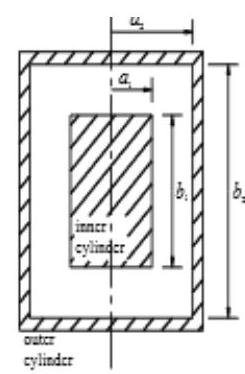

In [6]:
ocr_response